In [1]:
import pandas as pd
import numpy as np
import sqlite3
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from scipy.stats import ttest_ind
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, accuracy_score
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

In [2]:
dbfile = "shop_database.db"
conn = sqlite3.connect(dbfile)
cursor = conn.cursor()

df1 = pd.read_sql_query("SELECT \
                          pd.* \
                        FROM \
                          personal_data AS pd \
                         ", conn)

df2 = pd.read_sql_query("SELECT \
                          pdc.id, \
                          pdc.personal_coef \
                        FROM \
                          personal_data_coeffs AS pdc \
                         ", conn)

df3 = pd.read_sql_query("SELECT \
                          p.* \
                        FROM \
                          purchases AS p \
                         ", conn)

In [3]:
df4 = pd.read_csv('personal_data.csv')

df = df1.merge(df4, how='outer')
df = df.merge(df2)
df = df.merge(df3)

df = df[df.country == 32]
df['product'] = df['product'].apply(lambda x: x.lower())
df['colour'] = df['colour'].str.replace('/', ',').fillna('другой')
df['product_sex'] = df['product_sex'].fillna(0.5)

In [4]:
positive_a_b = open('ids_first_company_positive.txt', 'r').read().replace('\n', '').replace('Ids of positive AB people ', '').replace('ahashdgfjshjsd', ',').replace('dtj hfghfg yfsdftff', ',').replace(';', ',').replace(' ', ',').split(',')
positive_a_b = list(map(int, positive_a_b))
df['positive_a_b'] = df['id'][((df.dt>=5)&(df.dt<=16))].apply(lambda x: 1 if x in positive_a_b else 0)
df['positive_a_b'] = df['positive_a_b'].fillna(0)

negative_a_b = open('ids_first_company_negative.txt', 'r').read().replace('Ids of negative AB people ', '').replace('kdkdjff;;', '').replace('hsdghdshgd  hdhdhdhd', ',').replace('\n', '').replace(';', ',').replace('  ', ',').replace(' ', ',').replace('|||', ',').split(',')
negative_a_b = list(map(int, negative_a_b))
df['negative_a_b'] = df['id'][((df.dt>=5)&(df.dt<=16))].apply(lambda x: 1 if x in negative_a_b else 0)
df['negative_a_b'] = df['negative_a_b'].fillna(0)

df['ad_banner'] = df['dt'][df.city == 1134].apply(lambda x: 1 if x==15 else 1 if x==45 else 0)
df['ad_banner'] = df['ad_banner'].fillna(0)

In [5]:
df_std = df.copy()

data_ore = df_std[['product', 'colour']]
ore = OrdinalEncoder()
ore.fit(data_ore)
ore_data = ore.transform(data_ore)
df_std[['product_ore', 'colour_ore']] = ore_data
df_std = df_std.drop(columns = ['product', 'colour'])

data_ohe = df_std[['education']]
ohe = OneHotEncoder(sparse = False)
ohe.fit(data_ohe)
ohe_data = ohe.transform(data_ohe)
ohe.get_feature_names_out()
df_std[ohe.get_feature_names_out()] = ohe_data
df_std = df_std.drop(columns = ['id', 'education'])

columns = df_std.drop(columns = 'gender').columns
data_ssc = df_std[columns]
ssc = StandardScaler()
ssc.fit(data_ssc)
df_ssc = ssc.transform(data_ssc)
ssc.get_feature_names_out() + '_std'
df_std[ssc.get_feature_names_out() + '_std'] = df_ssc
df_std = df_std.drop(columns = columns)

In [6]:
train = df_std[~df_std.gender.isna()]
test = df_std[df_std.gender.isna()]

x_train = train.drop(['gender'], axis=1)
y_train = train['gender']
x_test = test.drop(['gender'], axis=1)

lr = LogisticRegression()
lr.fit(x_train, y_train)
lr_test = lr.predict(x_test)

df.loc[df.gender.isna(), 'gender'] = lr_test
df_std.loc[df_std.gender.isna(), 'gender'] = lr_test

In [7]:
df_positive_a_b = df[(df.positive_a_b == 1)]
df_negative_a_b = df[(df.negative_a_b == 1)]

conversion_positive_a_b = df_positive_a_b.id.nunique() / len(positive_a_b)
conversion_negative_a_b = df_negative_a_b.id.nunique() / len(negative_a_b)

print('Конверсия в группе с предложенной скидкой =', conversion_positive_a_b*100, '%')

Конверсия в группе с предложенной скидкой = 95.5 %


In [8]:
sale_positive = np.array(df_positive_a_b.cost.values)
sale_negative = np.array(df_negative_a_b.cost.values)

print('Сумма продаж в группе с предложенной скидкой =', round(sale_positive.sum()/1000000, 2), 'млн.')
print('Сумма продаж в группе без скидки =', round(sale_negative.sum()/1000000, 2), 'млн.')

print(ttest_ind(sale_positive, sale_negative, equal_var=False))

Сумма продаж в группе с предложенной скидкой = 132.72 млн.
Сумма продаж в группе без скидки = 111.35 млн.
Ttest_indResult(statistic=-3.2158974668795293, pvalue=0.0013013783623663092)


In [9]:
data_result_a_b = [{'group_type':'positive_a_b', 'sale_sum':round(sale_positive.sum()/1000000, 2)}, 
                   {'group_type':'negative_a_b', 'sale_sum':round(sale_negative.sum()/1000000, 2)}]
df_result_a_b = pd.DataFrame(data_result_a_b)

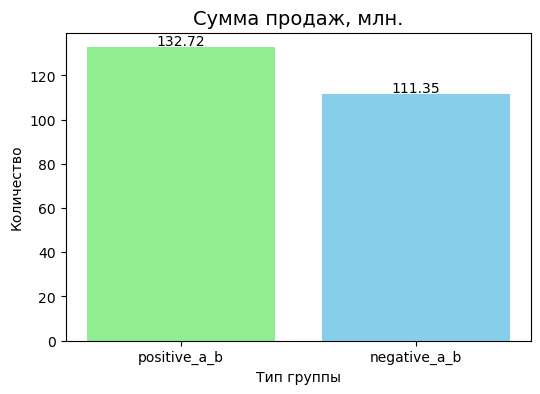

In [10]:
plt.figure(figsize=(6,4))
plt.bar(df_result_a_b['group_type'], df_result_a_b['sale_sum'], color=['lightgreen', 'skyblue'])
plt.title('Сумма продаж, млн.', fontsize=14)
plt.xlabel('Тип группы')
plt.ylabel('Количество')
for i, val in enumerate(df_result_a_b['sale_sum']):
    plt.text(i, val+1, str(val), ha='center')
plt.show()

In [11]:
df_new_std = df_std.drop(columns = ['positive_a_b_std', 'negative_a_b_std', 'ad_banner_std'])
df_new_std['id'] = df['id']
df_new_std = df_new_std.groupby('id').mean()

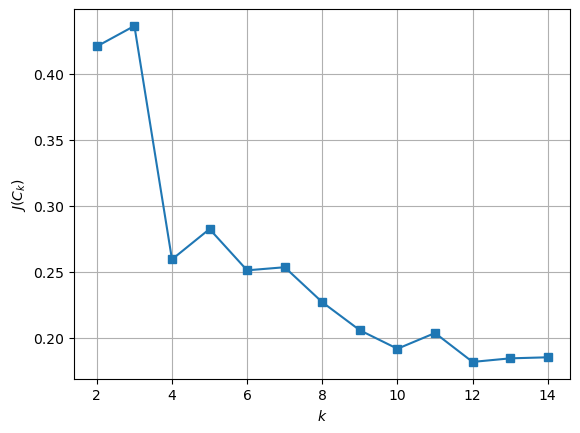

In [12]:
df_std_sample = df_new_std.sample(10000, random_state=42)
silhouette = []
N = 15
for k in range(2, N):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(df_std_sample)
    preds = kmeans.predict(df_std_sample)
    silhouette.append(silhouette_score(df_std_sample, preds))
    
plt.plot(range(2, N), silhouette, marker='s');
plt.xlabel('$k$')
plt.grid()
plt.ylabel('$J(C_k)$');

In [13]:
kmeans = KMeans(n_clusters=3, random_state=42).fit(df_new_std)

df_customers = df.copy()
df_customers['education'] = df_customers.education.apply(lambda x: 0 if x=='среднее' else 1) 
df_customers = df_customers.groupby('id', as_index=False).agg({'gender': 'mean', 'age':'mean', 'education':'mean', 'cost':['mean', 'sum', 'count']})
df_customers['cluster'] = kmeans.labels_+1
df_customers.columns = ['id', 'gender_mean', 'age_mean', 'education_mean', 'cost_mean', 'cost_sum', 'pay_count', 'cluster']
df_customers['customers_count'] = 0

df_clusters = df_customers.groupby('cluster').agg({'gender_mean': 'mean', 'age_mean':'mean', 'education_mean':'mean', 'cost_mean':'mean', 'cost_sum':'sum', 'pay_count':'sum', 'customers_count':'count'})
df_clusters['education_mean'] = df_clusters['education_mean'] * 100
df_clusters['cost_sum_mln'] = df_clusters['cost_sum'] / 1000000
df_clusters['pay_count_ths'] = df_clusters['pay_count'] / 1000
df_clusters['customers_count_ths'] = df_clusters['customers_count'] / 1000
df_clusters = round(df_clusters, 2).drop(columns = ['cost_sum', 'pay_count', 'customers_count'])

df_clusters

,gender_mean,age_mean,education_mean,cost_mean,cost_sum_mln,pay_count_ths,customers_count_ths
cluster,,,,,,,
1,0.70,24.67,100.00,6253.22,910.16,155.92,22.64
2,0.99,40.93,0.00,7069.81,2112.05,326.96,44.22
3,0.02,42.65,0.06,4263.27,1200.16,297.24,37.58


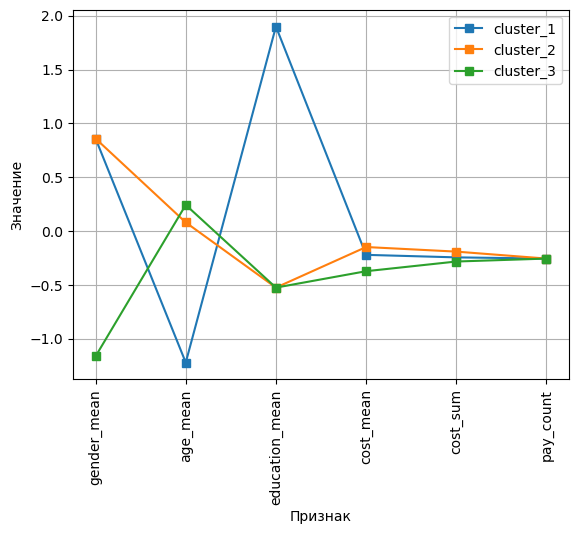

In [14]:
df_g = ssc.fit_transform(df_customers.drop(columns = ['id', 'cluster', 'customers_count']))

plt.plot(df_customers.drop(columns = ['id', 'cluster', 'customers_count']).columns, np.median(df_g[kmeans.labels_ == 0], axis=0), marker='s', label='cluster_1');
plt.plot(df_customers.drop(columns = ['id', 'cluster', 'customers_count']).columns, np.median(df_g[kmeans.labels_ == 1], axis=0), marker='s', label='cluster_2');
plt.plot(df_customers.drop(columns = ['id', 'cluster', 'customers_count']).columns, np.median(df_g[kmeans.labels_ == 2], axis=0), marker='s', label='cluster_3');
plt.legend()
plt.xticks(rotation=90)
plt.xlabel('Признак')
plt.grid()
plt.ylabel('Значение');

In [15]:
cluster_1 = list(df_customers[df_customers.cluster == 1]['id'])
cluster_2 = list(df_customers[df_customers.cluster == 2]['id'])
cluster_3 = list(df_customers[df_customers.cluster == 3]['id'])

df_new = df.copy()
df_new['count_pay'] = 0
df_new['cluster'] = df_new['id'].apply(lambda x: 1 if x in cluster_1 else 2 if x in cluster_2 else 3)
df_new['product'] = df_new['product'].str.split(' ').apply(lambda x: x[0])

df_cl_1 = df_new[['product', 'count_pay']][df_new.cluster == 1].groupby('product', as_index=False).agg({'count_pay': 'count'}).sort_values(['count_pay'], ascending=False).head()
df_cl_2 = df_new[['product', 'count_pay']][df_new.cluster == 2].groupby('product', as_index=False).agg({'count_pay': 'count'}).sort_values(['count_pay'], ascending=False).head()
df_cl_3 = df_new[['product', 'count_pay']][df_new.cluster == 3].groupby('product', as_index=False).agg({'count_pay': 'count'}).sort_values(['count_pay'], ascending=False).head()

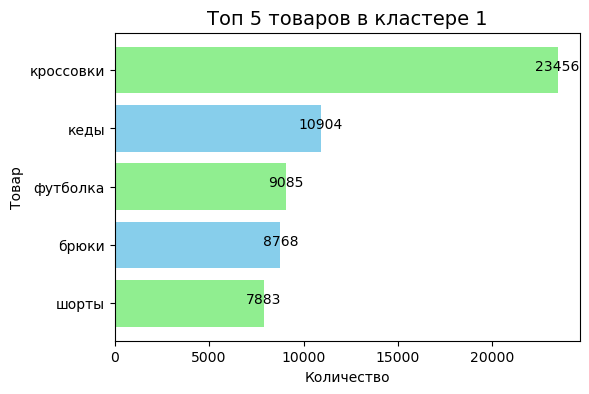

In [16]:
df_cl_1 = df_cl_1.sort_values(['count_pay'])
plt.figure(figsize=(6,4))
plt.barh(df_cl_1['product'], df_cl_1['count_pay'], color=['lightgreen', 'skyblue'])
plt.title('Топ 5 товаров в кластере 1', fontsize=14)
plt.xlabel('Количество')
plt.ylabel('Товар')
for i, val in enumerate(df_cl_1['count_pay'].sort_values()):
    plt.text(x=val, y=i, s=str(val), ha='center')
plt.show()

In [17]:
df_std_1188 = df_std[df.city == 1188]
df_std_1188['product'] = df['product'][df.city == 1188].str.split(' ').apply(lambda x: x[0])

x = df_std_1188.drop(['product'], axis=1)
y = df_std_1188['product']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

rf_clf = RandomForestClassifier(random_state=42, bootstrap=False, class_weight='balanced', min_samples_split=4, n_estimators=70)
rf_clf.fit(x_train, y_train)
rf_clf_test = rf_clf.predict(x_test)

print('Результат модели предсказания =', round(accuracy_score(y_test, rf_clf_test)*100, 2), '%' )

Результат модели предсказания = 82.84 %
